<a href="https://colab.research.google.com/github/khalidakram07/Time_Series_Forcasting/blob/main/Prophetforecaster1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
from pandas import datetime

import fbprophet
from fbprophet import Prophet

from fbprophet.plot import add_changepoints_to_plot
from pandas import read_csv
from matplotlib import pyplot


In [4]:
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

In [63]:
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = read_csv(path, header=0,index_col=[0], parse_dates=[0]) # We set the index column and know it has dates)))


In [7]:
df

,Sales
Month,
1960-01-01,6550
1960-02-01,8728
1960-03-01,12026
1960-04-01,14395
1960-05-01,14587
...,...
1968-08-01,16722
1968-09-01,14385
1968-10-01,21342


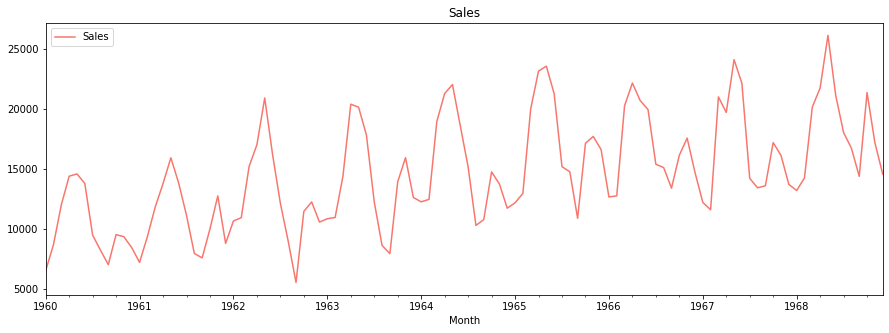

In [69]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
df.plot(figsize=(15,5), color=color_pal[0], title='Sales')
plt.show()

# EDA

We will create some time series features to see how the trends are impacted by day of week, hour, time of year, etc.

In [11]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='Sales')

features_and_target = pd.concat([X, y], axis=1)

In [62]:
features_and_target.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Sales
Month,,,,,,,,
1960-01-01,4,1,1,1960,1,1,53,6550
1960-02-01,0,1,2,1960,32,1,5,8728
1960-03-01,1,1,3,1960,61,1,9,12026
1960-04-01,4,2,4,1960,92,1,13,14395
1960-05-01,6,2,5,1960,122,1,17,14587


In [33]:
features_and_target.describe()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Sales
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.0,108.000000,108.000000
mean,2.990741,2.500000,6.500000,1964.000000,167.777778,1.0,26.712963,14595.111111
std,1.992957,1.123246,3.468146,2.594026,105.583057,0.0,15.170095,4525.213913
min,0.000000,1.000000,1.000000,1960.000000,1.000000,1.0,1.000000,5568.000000
25%,1.000000,1.750000,3.750000,1962.000000,83.500000,1.0,13.000000,11391.250000
50%,3.000000,2.500000,6.500000,1964.000000,167.500000,1.0,26.000000,14076.000000
75%,5.000000,3.250000,9.250000,1966.000000,252.250000,1.0,39.250000,17595.750000
max,6.000000,4.000000,12.000000,1968.000000,336.000000,1.0,53.000000,26099.000000


We can infer from the following that highest sale has been made on Thursday overall with sales upto 257859

In [13]:
highest_sold=features_and_target.groupby(['dayofweek']).sum()
highest_sold[['Sales']]

,Sales
dayofweek,
0,249089
1,204183
2,247837
3,210645
4,257859
5,198561
6,208098


Plotting the Features to see trends
Sale demand has strong daily and seasonal properties.
Day of week also seems to show differences in peaks


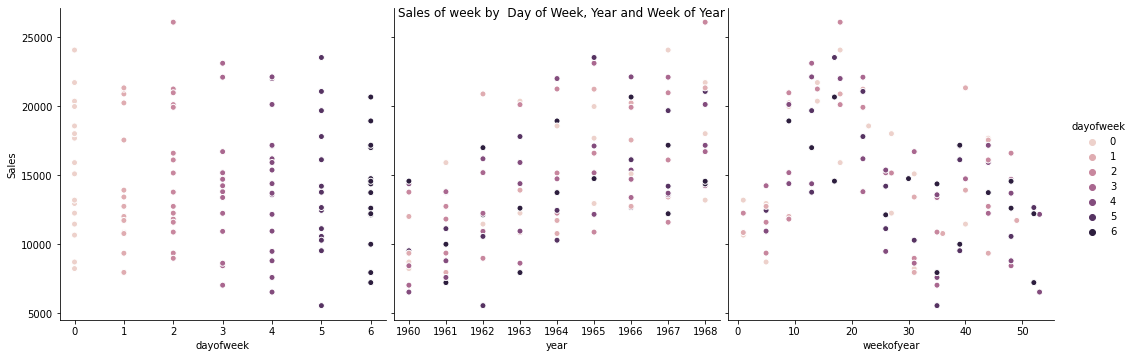

In [18]:
sns.pairplot(features_and_target.dropna(),
             hue='dayofweek',
             x_vars=['dayofweek',
                     'year','weekofyear'],
             y_vars='Sales',
             height=5,
             plot_kws={'alpha':1, 'linewidth':1}
            )
plt.suptitle('Sales of week by  Day of Week, Year and Week of Year')
plt.show()

In [81]:
#Splitting the dataset from 1966
split_date = '1966-01-01'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()


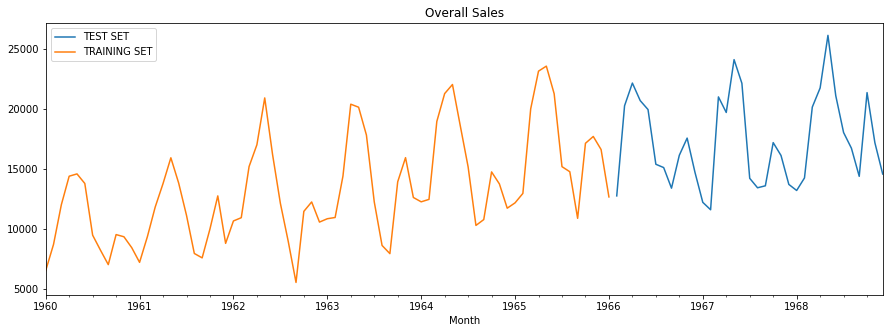

In [82]:
# Plot train and test so you can see where we have split
df_test \
    .rename(columns={'Sales': 'TEST SET'}) \
    .join(df_train.rename(columns={'Sales': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Overall Sales', )
plt.show()

In [83]:
# Setup and train model and fit
model = Prophet()
model.fit(df_train.reset_index() \
              .rename(columns={'Month':'ds',
                               'Sales':'y'}))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [84]:
# Predict on training set with model
df_test_fcst = model.predict(df=df_test.reset_index() \
                                   .rename(columns={'Month':'ds'}))
df_test_fcst.head(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1966-02-01,17635.469493,14297.905947,17135.863551,17635.469040,17635.470132,-1906.272580,-1906.272580,-1906.272580,-1906.272580,-1906.272580,-1906.272580,0.0,0.0,0.0,15729.196914
1,1966-03-01,17739.964688,18038.904394,20754.877321,17739.960863,17739.969022,1671.368204,1671.368204,1671.368204,1671.368204,1671.368204,1671.368204,0.0,0.0,0.0,19411.332892
2,1966-04-01,17855.655795,21887.857295,24477.724702,17855.646028,17855.666936,5400.065718,5400.065718,5400.065718,5400.065718,5400.065718,5400.065718,0.0,0.0,0.0,23255.721513
3,1966-05-01,17967.614932,23524.793496,26017.620369,17967.598536,17967.633666,6797.775166,6797.775166,6797.775166,6797.775166,6797.775166,6797.775166,0.0,0.0,0.0,24765.390098
4,1966-06-01,18083.306040,20688.169713,23228.084533,18083.281950,18083.333645,3899.479720,3899.479720,3899.479720,3899.479720,3899.479720,3899.479720,0.0,0.0,0.0,21982.785760


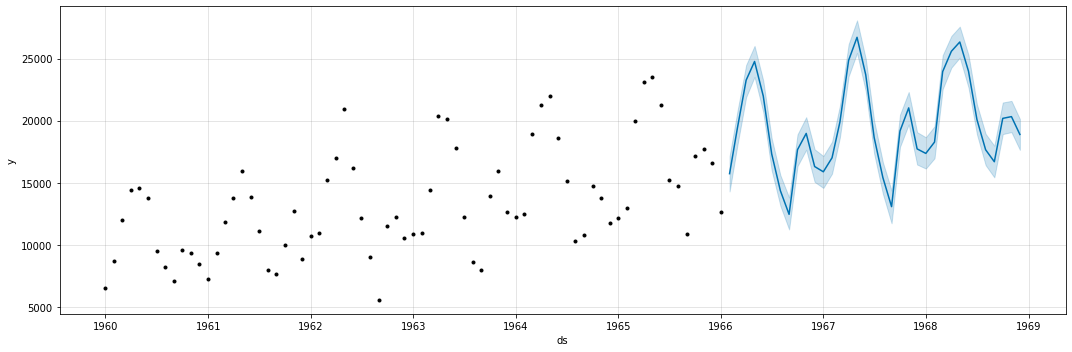

In [86]:
# Plot the forecast for trained model
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(df_test_fcst,ax=ax
                 )
plt.show()

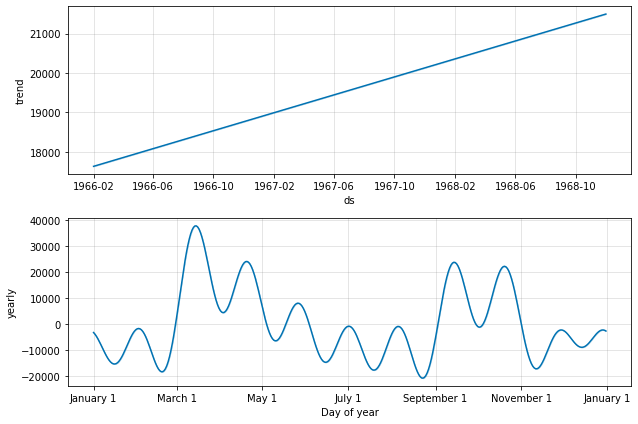

In [87]:
# Plot the components of the model
fig = model.plot_components(df_test_fcst)

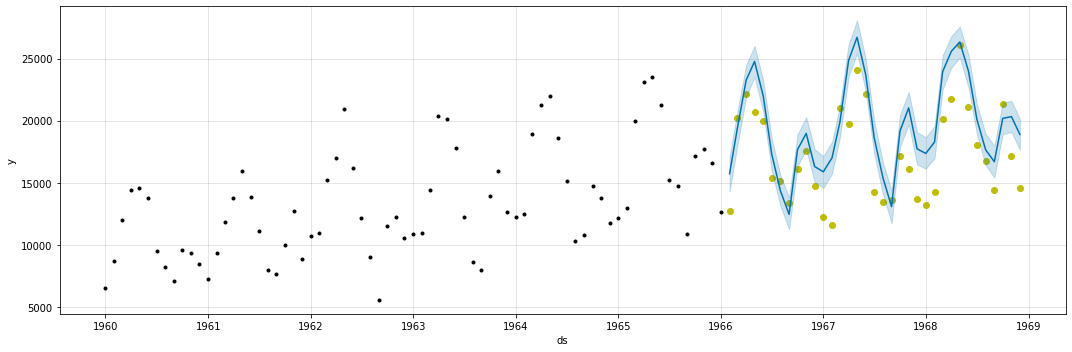

In [88]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test.index, df_test['Sales'], color='y')
fig = model.plot(df_test_fcst, ax=ax)

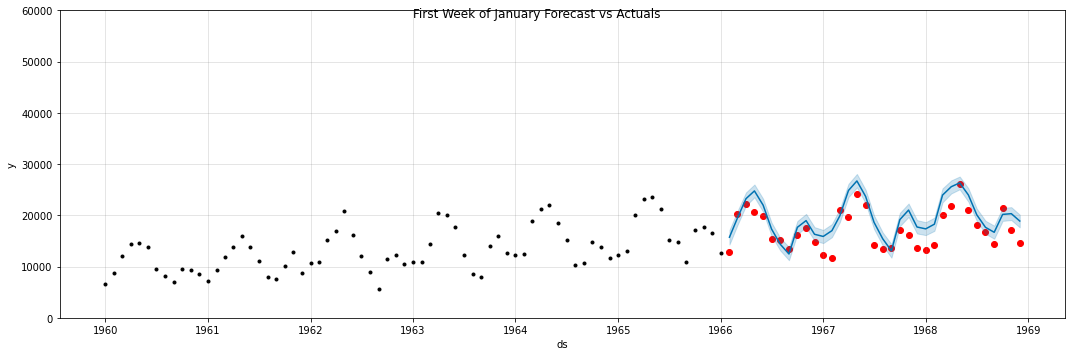

In [104]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test.index, df_test['Sales'], color='r')
fig = model.plot(df_test_fcst, ax=ax)
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

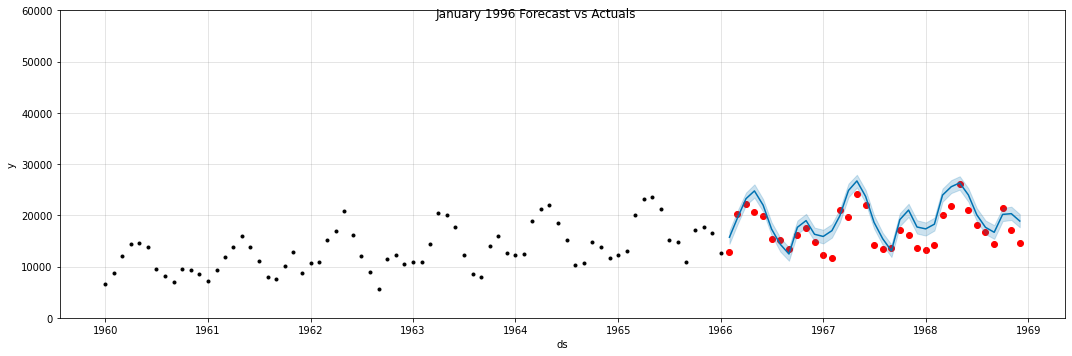

In [58]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test.index, df_test['Sales'], color='r')
fig = model.plot(df_test_fcst, ax=ax)

ax.set_ylim(0, 60000)
plot = plt.suptitle('January 1996 Forecast vs Actuals')

In [49]:
from sklearn.neural_network import MLPRegressor 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [50]:
mean_squared_error(y_true=df_test['Sales'],
                   y_pred=df_test_fcst['yhat'])


8652706.394703766

In [48]:
mean_absolute_error(y_true=df_test['Sales'],
                   y_pred=df_test_fcst['yhat'])

2556.241351856826

In [51]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=df_test['Sales'],
                   y_pred=df_test_fcst['yhat'])

15.988621736581294

Our RMSE error is 8652706.39
Our MAE error is 2556
Our MAPE error is 15.985%

In [52]:
future = model.make_future_dataframe(periods=3)
forecast = model.predict(future)

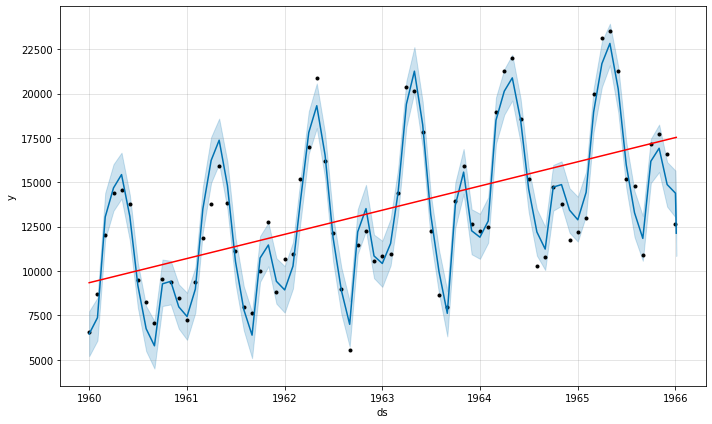

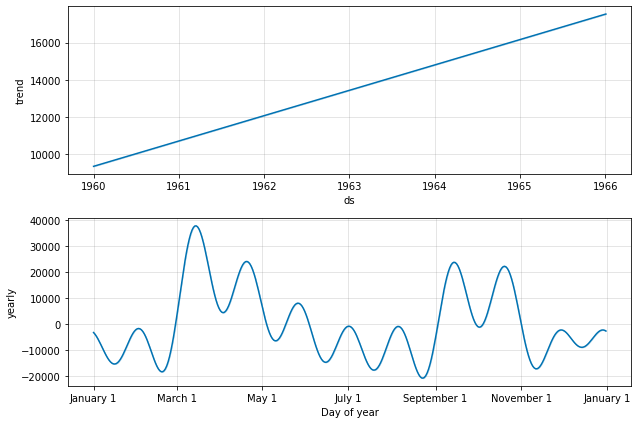

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
71,1965-12-01,17404.087278,13626.818773,16142.710706,17404.087278,17404.087278,-2530.936123,-2530.936123,-2530.936123,-2530.936123,-2530.936123,-2530.936123,0.0,0.0,0.0,14873.151154
72,1966-01-01,17519.778385,13029.698994,15660.436345,17519.778385,17519.778385,-3130.954431,-3130.954431,-3130.954431,-3130.954431,-3130.954431,-3130.954431,0.0,0.0,0.0,14388.823954
73,1966-01-02,17523.510357,12518.756686,15001.327472,17523.510357,17523.510357,-3744.741908,-3744.741908,-3744.741908,-3744.741908,-3744.741908,-3744.741908,0.0,0.0,0.0,13778.768449
74,1966-01-03,17527.242328,11653.070313,14245.850791,17527.242328,17527.242328,-4506.538370,-4506.538370,-4506.538370,-4506.538370,-4506.538370,-4506.538370,0.0,0.0,0.0,13020.703958
75,1966-01-04,17530.974299,10855.925276,13414.923116,17530.974299,17530.974299,-5397.584880,-5397.584880,-5397.584880,-5397.584880,-5397.584880,-5397.584880,0.0,0.0,0.0,12133.389419


In [53]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)
from matplotlib import pyplot as plt
plt.show()
fig2 = model.plot_components(forecast)
plt.show()
forecast.tail()

In [55]:
type(forecast)

pandas.core.frame.DataFrame